# Query Sequence Analysis

This notebook focuses on sequence analysis, when presented with a workload schedule / sequence of queries. In an average day to day work activity, particular query patterns can be discerned. This pattern distinction allows us to discern which queries will be susceptible to execution over time, allowing us to know ahead of time which queries will be executed against the database.

### Module Installation and Importing Libraries

In [16]:
# scipy
import scipy as sc
print('scipy: %s' % sc.__version__)
# numpy
import numpy as np
print('numpy: %s' % np.__version__)
# matplotlib
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
# pandas
import pandas as pd
print('pandas: %s' % pd.__version__)
# scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score
import sklearn as sk
print('sklearn: %s' % sk.__version__)
# keras
import keras as ke
from keras.layers import Embedding, Flatten
from keras.utils import np_utils
print('keras: %s' % ke.__version__)
import math

scipy: 1.1.0
numpy: 1.15.2
pandas: 0.23.4
sklearn: 0.19.0
keras: 2.2.4


### Configuration Cell

Tweak parametric changes from this cell to influence outcome of experiment. 
NB: This experiment demonstrates at time  step = 1 (1 minute in advance). Further down in experiment, other timestep results are also featured and evaluated.

In [17]:
#
# Experiment Config
tpcds='TPCDS1' # Schema upon which to operate test
lag=3 # Time Series shift / Lag Step. Each lag value equates to 1 minute. Cannot be less than 1
if lag < 1:
    raise ValueError('Lag value must be greater than 1!')
#
test_split=.2 # Denotes which Data Split to operate under when it comes to training / validation
y_label = ['SQL_ID'] # Denotes which label to use for time series experiments
#
# Forest Config
parallel_degree = 1
n_estimators = 10
#
# Net Config
batch_size=10
epochs=10

### Read data from file into Pandas Dataframes

In [18]:
#
# Open Data
rep_hist_snapshot_path = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds + '/v2/rep_hist_snapshot.csv'
#rep_hist_snapshot_path = 'D:/Projects/Datagenerated_ICS5200/Schedule/' + tpcds + '/v2/rep_hist_snapshot.csv'
#
rep_hist_snapshot_df = pd.read_csv(rep_hist_snapshot_path)
#
def prettify_header(headers):
    """
    Cleans header list from unwated character strings
    """
    header_list = []
    [header_list.append(header.replace("(","").replace(")","").replace("'","").replace(",","")) for header in headers]
    return header_list
#
rep_hist_snapshot_df.columns = prettify_header(rep_hist_snapshot_df.columns.values)
#
print(rep_hist_snapshot_df.columns.values)

['SNAP_ID' 'DBID' 'INSTANCE_NUMBER' 'SQL_ID' 'PLAN_HASH_VALUE'
 'OPTIMIZER_COST' 'OPTIMIZER_MODE' 'OPTIMIZER_ENV_HASH_VALUE'
 'SHARABLE_MEM' 'LOADED_VERSIONS' 'VERSION_COUNT' 'MODULE' 'ACTION'
 'SQL_PROFILE' 'FORCE_MATCHING_SIGNATURE' 'PARSING_SCHEMA_ID'
 'PARSING_SCHEMA_NAME' 'PARSING_USER_ID' 'FETCHES_TOTAL' 'FETCHES_DELTA'
 'END_OF_FETCH_COUNT_TOTAL' 'END_OF_FETCH_COUNT_DELTA' 'SORTS_TOTAL'
 'SORTS_DELTA' 'EXECUTIONS_TOTAL' 'EXECUTIONS_DELTA'
 'PX_SERVERS_EXECS_TOTAL' 'PX_SERVERS_EXECS_DELTA' 'LOADS_TOTAL'
 'LOADS_DELTA' 'INVALIDATIONS_TOTAL' 'INVALIDATIONS_DELTA'
 'PARSE_CALLS_TOTAL' 'PARSE_CALLS_DELTA' 'DISK_READS_TOTAL'
 'DISK_READS_DELTA' 'BUFFER_GETS_TOTAL' 'BUFFER_GETS_DELTA'
 'ROWS_PROCESSED_TOTAL' 'ROWS_PROCESSED_DELTA' 'CPU_TIME_TOTAL'
 'CPU_TIME_DELTA' 'ELAPSED_TIME_TOTAL' 'ELAPSED_TIME_DELTA' 'IOWAIT_TOTAL'
 'IOWAIT_DELTA' 'CLWAIT_TOTAL' 'CLWAIT_DELTA' 'APWAIT_TOTAL'
 'APWAIT_DELTA' 'CCWAIT_TOTAL' 'CCWAIT_DELTA' 'DIRECT_WRITES_TOTAL'
 'DIRECT_WRITES_DELTA' 'PLSEXEC_TIME_T

### Changing Matrix Shapes

Changes dataframe shape, in an attempt to drop all numeric data. Below's aggregated data is done so on:
* SNAP_ID
* INSTANCE_NUMBER
* DBID
* SQL_ID

In [19]:
print("Shape Before Aggregation: " + str(rep_hist_snapshot_df.shape))
#
# Group By Values by SNAP_ID , sum all metrics (for table REP_HIST_SNAPSHOT) and drop all numeric
rep_hist_snapshot_df = rep_hist_snapshot_df.groupby(['SNAP_ID','DBID','INSTANCE_NUMBER','SQL_ID']).sum()
rep_hist_snapshot_df.reset_index(inplace=True)
#
print("Shape After Aggregation: " + str(rep_hist_snapshot_df.shape))

Shape Before Aggregation: (2230, 90)
Shape After Aggregation: (1923, 78)


### Dealing with Empty Values

In [20]:
def get_na_columns(df, headers):
    """
    Return columns which consist of NAN values
    """
    na_list = []
    for head in headers:
        if df[head].isnull().values.any():
            na_list.append(head)
    return na_list
#
print('N/A Columns\n')
print('\n REP_HIST_SNAPSHOT Features ' + str(len(rep_hist_snapshot_df.columns)) + ': ' + str(get_na_columns(df=rep_hist_snapshot_df,headers=rep_hist_snapshot_df.columns)) + "\n")
#
def fill_na(df):
    """
    Replaces NA columns with 0s
    """
    return df.fillna(0)
#
# Populating NaN values with amount '0'
df = fill_na(df=rep_hist_snapshot_df)

N/A Columns


 REP_HIST_SNAPSHOT Features 78: []



### Data Ordering

Sorting of datasets in order of SNAP_ID.

In [21]:
df.sort_values(by=['SNAP_ID'], ascending=True, inplace=True)
print(df.shape)

(1923, 78)


### Floating point precision conversion

Each column is converted into a column of type values which are floating point for higher precision.

In [22]:
for column in df.columns:
    try:
        df[column].astype('float32', inplace=True)
        df[column] = np.round(df[column], 3) # rounds to 3 dp
    except:
        print('Couldnt convert column [' + column + ']')
print(df.shape)

Couldnt convert column [SQL_ID]
(1923, 78)


### Feature Selection

In this step, redundant features are dropped. Features are considered redundant if exhibit a standard devaition of 0 (meaning no change in value).

In [23]:
def drop_flatline_columns(df):
    columns = df.columns
    flatline_features = []
    for i in range(len(columns)):
        try:
            std = df[columns[i]].std()
            if std == 0:
                flatline_features.append(columns[i])
        except:
            pass
    #
    #print('Features which are considered flatline:\n')
    #for col in flatline_features:
    #    print(col)
    print('\nShape before changes: [' + str(df.shape) + ']')
    df = df.drop(columns=flatline_features)
    print('Shape after changes: [' + str(df.shape) + ']')
    print('Dropped a total [' + str(len(flatline_features)) + ']')
    return df
#
print('Before column drop:')
print(df.shape)
df = drop_flatline_columns(df=df)
print('\nAfter flatline column drop:')
print(df.shape)
dropped_columns_df = [ 'PLAN_HASH_VALUE',
                       'OPTIMIZER_ENV_HASH_VALUE',
                       'LOADED_VERSIONS',
                       'VERSION_COUNT',
                       'PARSING_SCHEMA_ID',
                       'PARSING_USER_ID',
                       'CON_DBID',
                       'SNAP_LEVEL',
                       'SNAP_FLAG',
                       'COMMAND_TYPE',
                       'FLAG']
df.drop(columns=dropped_columns_df, inplace=True)
print('\nAfter additional column drop:')
print(df.shape)

Before column drop:
(1923, 78)

Shape before changes: [(1923, 78)]
Shape after changes: [(1923, 63)]
Dropped a total [15]

After flatline column drop:
(1923, 63)

After additional column drop:
(1923, 52)


### Data Normalization

Under the assumption that outliers have been capped/transformed, data is now passed through a min-max transformer.

In [24]:
#
# Keep reference of label before normalizaing
y_df = df[y_label]
df.drop(columns=y_label, inplace=True)
#
# Normalize values
scaler = MinMaxScaler(feature_range=(0, 1))
df_normalized_values = scaler.fit_transform(df.values)
#
# Carry normalized values (numpy array) to pandas df
df = pd.DataFrame(data=df_normalized_values, columns=df.columns)
del df_normalized_values
#
# Combine back labels to normalized values
df = pd.concat([y_df, df], axis=1, join_axes=[y_df.index])
#
print(str(df.shape))
print(df.head())

(1923, 52)
           SQL_ID  SNAP_ID  OPTIMIZER_COST  SHARABLE_MEM  FETCHES_TOTAL  \
0   03ggjrmy0wa1w      0.0    2.117521e-10      0.000188   2.555851e-08   
26  8mdz49zkajhw3      0.0    2.018526e-10      0.000274   3.949952e-08   
27  8t26unxsrxj72      0.0    7.243516e-11      0.000101   9.294005e-09   
28  93n8wp5a8xyxn      0.0    6.905485e-11      0.000198   3.485252e-08   
29  9ggx4p02d346a      0.0    3.138857e-12      0.000466   2.323501e-09   

    FETCHES_DELTA  END_OF_FETCH_COUNT_TOTAL  END_OF_FETCH_COUNT_DELTA  \
0        0.000023              4.341988e-07                  0.000387   
26       0.000023              6.710345e-07                  0.000387   
27       0.000023              1.578905e-07                  0.000387   
28       0.000023              5.920892e-07                  0.000387   
29       0.000023              3.947262e-08                  0.000387   

    SORTS_TOTAL  SORTS_DELTA              ...                \
0      0.000079     0.070267        

### Rearranging Labels

Removes the label column, and adds it at the beginning of the matrix for later usage

In [25]:
print('Before Column Switch: ' + str(df.shape))
y_df = df[y_label]
df.drop(columns=y_label, inplace=True)
print("Label " + str(y_label) + " shape: " + str(y_df.shape))
print("Feature matrix shape: " + str(df.shape))
#
# Merging labels and features in respective order
df = pd.concat([y_df, df], axis=1, sort=False)
print('After Column Switch: ' + str(df.shape))
print(df.head())

Before Column Switch: (1923, 52)
Label ['SQL_ID'] shape: (1923, 1)
Feature matrix shape: (1923, 51)
After Column Switch: (1923, 52)
           SQL_ID  SNAP_ID  OPTIMIZER_COST  SHARABLE_MEM  FETCHES_TOTAL  \
0   03ggjrmy0wa1w      0.0    2.117521e-10      0.000188   2.555851e-08   
26  8mdz49zkajhw3      0.0    2.018526e-10      0.000274   3.949952e-08   
27  8t26unxsrxj72      0.0    7.243516e-11      0.000101   9.294005e-09   
28  93n8wp5a8xyxn      0.0    6.905485e-11      0.000198   3.485252e-08   
29  9ggx4p02d346a      0.0    3.138857e-12      0.000466   2.323501e-09   

    FETCHES_DELTA  END_OF_FETCH_COUNT_TOTAL  END_OF_FETCH_COUNT_DELTA  \
0        0.000023              4.341988e-07                  0.000387   
26       0.000023              6.710345e-07                  0.000387   
27       0.000023              1.578905e-07                  0.000387   
28       0.000023              5.920892e-07                  0.000387   
29       0.000023              3.947262e-08         

### Label Encoding

Since this experiment deals with prediction of upcoming SQL_IDs, respectice SQL_ID strings need to labelled as a numeric representation. Label Encoder will be used here to convert SQL_ID's into a numeric format, which are in turn used for training. Evaluation (achieved predictions) is done so also in numeric format, at which point the label encoder is eventually used to decode back the labels into the original, respetive SQL_ID representation.

This section of the experiment additionally converts the targetted label into a binarized version of the previous achieved categorical numeric values.

* https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html

In [26]:
### Label Encoding
#
# Since this experiment deals with prediction of upcoming SQL_IDs, respectice SQL_ID strings need to labelled as a numeric representation. Label Encoder will be used here to convert SQL_ID's into a numeric format, which are in turn used for training. Evaluation (achieved predictions) is done so also in numeric format, at which point the label encoder is eventually used to decode back the labels into the original, respetive SQL_ID representation.
print("Before label encoding: " + str(df.shape))
le = preprocessing.LabelEncoder()
le.fit(df['SQL_ID'])
df['SQL_ID'] = le.transform(df['SQL_ID'])
print("After label encoding: " + str(df.shape) + "\n----------------------------------\n\nAvailable Classes:")
print(len(le.classes_))
print(le.classes_)
print(df.head())

Before label encoding: (1923, 52)
After label encoding: (1923, 52)
----------------------------------

Available Classes:
379
['01d5n1nm17r2h' '01tp87bk1t2zv' '03ggjrmy0wa1w' '04kug40zbu4dm'
 '06dymzb481vnd' '06g9mhm5ba7tt' '09vrdx888wvvb' '0a08ug2qc1j82'
 '0a7q9v9nd2qc1' '0aq14dznn91rg' '0f60bzgt9127c' '0ga8vk4nftz45'
 '0hdquu87pydzk' '0hhmdwwgxbw0r' '0jj0ct4x4gy27' '0kcbwucxmazcp'
 '0kkhhb2w93cx0' '0m78skf1mudnb' '0qbzfjt00pbsx' '0v3dvmc22qnam'
 '0vcz1xqfrykmw' '0w26sk6t6gq98' '0x6ks1umjn6k6' '0y080mnfaqk3u'
 '0ym9wzzys5zax' '130r442w3nfny' '13a9r2xkx1bxb' '13ys8ux8xvrbm'
 '14f5ngrj3cc5h' '14kx436hrv7cc' '193ncz0tf25hw' '1aajwypydy0wu'
 '1c3x1d7pc0cmt' '1fn8v91f0arf0' '1gfaj4z5hn1kf' '1hxfbnas8xr2j'
 '1jhyrdp21f2q6' '1k33bhcnpbrwx' '1kz16yhs993h2' '1ms8wj24sqny4'
 '1p5grz1gs7fjq' '1pgnzc6zf7ctc' '1pv23p59mjs0v' '1r7b985mxqj71'
 '1rpgk59t8pvs6' '1u97hwfu7dcmz' '1v2b661suttyp' '1wk0t84cwr5ps'
 '1wpns6pagm2qj' '1wq6da7n103qd' '1wz811srf8xh8' '2046z7kdh823h'
 '20bqsr6btd9x9' '20vv6ttajyj

### Time Series Shifting

Shifting the datasets N lag minutes, in order to transform the problem into a supervised dataset. Each Lag Shift equates to 60 seconds (due to the way design of the data capturing tool). For each denoted lag amount, the same number of feature vectors will be stripped away at the beginning.

Features and Labels are separated into seperate dataframes at this point.

https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [27]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = data
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    if n_in != 0:
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    n_out += 1
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
#
def remove_n_time_steps(data, n=1):
    if n == 0:
        return data
    df = data
    headers = df.columns
    dropped_headers = []
    #     for header in headers:
    #         if "(t)" in header:
    #             dropped_headers.append(header)
    #
    for i in range(1,n+1):
        for header in headers:
            if "(t+"+str(i)+")" in header:
                dropped_headers.append(str(header))
    #
    return df.drop(dropped_headers, axis=1) 
#
# Frame as supervised learning set
shifted_df = series_to_supervised(df, lag, lag)
#
# Seperate labels from features
y_row = []
for i in range(lag+1,(lag*2)+2):
    y_df_column_names = shifted_df.columns[len(df.columns)*i:len(df.columns)*i + len(y_label)]
    y_row.append(y_df_column_names)
y_df_column_names = []   
for row in y_row:
    for val in row:
        y_df_column_names.append(val)
#
# y_df_column_names = shifted_df.columns[len(df.columns)*lag:len(df.columns)*lag + len(y_label)]
y_df = shifted_df[y_df_column_names]
X_df = shifted_df.drop(columns=y_df_column_names)
print('\n-------------\nFeatures')
print(X_df.columns)
print(X_df.shape)
print('\n-------------\nLabels')
print(y_df.columns)
print(y_df.shape)
#
# Delete middle timesteps
X_df = remove_n_time_steps(data=X_df, n=lag)
print('\n-------------\nFeatures After Time Shift')
print(X_df.columns)
print(X_df.shape)
# y_df = remove_n_time_steps(data=y_df, n=lag)
print('\n-------------\nLabels After Time Shift')
print(y_df.columns)
print(y_df.shape)


-------------
Features
Index(['var1(t-3)', 'var2(t-3)', 'var3(t-3)', 'var4(t-3)', 'var5(t-3)',
       'var6(t-3)', 'var7(t-3)', 'var8(t-3)', 'var9(t-3)', 'var10(t-3)',
       ...
       'var43(t+3)', 'var44(t+3)', 'var45(t+3)', 'var46(t+3)', 'var47(t+3)',
       'var48(t+3)', 'var49(t+3)', 'var50(t+3)', 'var51(t+3)', 'var52(t+3)'],
      dtype='object', length=361)
(1917, 361)

-------------
Labels
Index(['var1(t+1)', 'var1(t+2)', 'var1(t+3)'], dtype='object')
(1917, 3)

-------------
Features After Time Shift
Index(['var1(t-3)', 'var2(t-3)', 'var3(t-3)', 'var4(t-3)', 'var5(t-3)',
       'var6(t-3)', 'var7(t-3)', 'var8(t-3)', 'var9(t-3)', 'var10(t-3)',
       ...
       'var43(t)', 'var44(t)', 'var45(t)', 'var46(t)', 'var47(t)', 'var48(t)',
       'var49(t)', 'var50(t)', 'var51(t)', 'var52(t)'],
      dtype='object', length=208)
(1917, 208)

-------------
Labels After Time Shift
Index(['var1(t+1)', 'var1(t+2)', 'var1(t+3)'], dtype='object')
(1917, 3)


### RandomForest Classification (Many To Many)

Classification attemps using RFC

In [28]:
#
# Random Forest
class RandomForest:
    """
    Random Forest Class (Regression + Classification)
    """
    #
    def __init__(self, mode, n_estimators, max_depth=None,parallel_degree=1):
        self.mode = self.__validate(mode)
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.parallel_degree=parallel_degree
        if self.mode == 'regression':
            #
            raise NotImplemented('Regression subtype is not supported for this experiment!')
        elif self.mode == 'classification':
            self.model = RandomForestClassifier(max_depth=self.max_depth,
                                                n_estimators=self.n_estimators,
                                                n_jobs=self.parallel_degree)
    #
    def __validate(self, mode):
        mode = mode.lower()
        if mode not in ('classification','regression'):
            raise ValueError('Specified mode is incorrect!')
        return mode
    #
    def fit_model(self, X_train, y_train):
        """
        Fits training data to target labels
        """
        self.model.fit(X_train,y_train)
        print(self.model)
    #
    def predict(self, X):
        yhat = self.model.predict(X)
        return yhat
    #
    def predict_and_evaluate(self, X, y, y_labels, plot=False):
        """
        Runs test data through previously trained model, and evaluate differently depending if a regression of classification model
        """
        yhat = self.predict(X)
        if self.mode == 'regression':
            #
            raise NotImplemented('Regression subtype is not supported for this experiment!')
            #
        elif self.mode == 'classification':
            #
            # F1-Score Evaluation
            for i in range(y.shape[1]):
                f1 = f1_score(y[:,i], yhat[:,i], average='micro') # Calculate metrics globally by counting the total true positives, false negatives and false positives.
                print('Test FScore ' + y_labels[0] + ' with LAG value [' + str(i) + ']: ' +  str(f1))
        #
        if plot:
            for i in range(0, len(y[0])):
                plt.rcParams['figure.figsize'] = [20, 15]
                plt.plot(y[:,i], label='actual')
                plt.plot(yhat[:,i], label='predicted')
                plt.legend(['actual', 'predicted'], loc='upper left')
                plt.title(y_labels[i%len(y_labels)] + " +" + str(math.ceil((i+1)/len(y_label))))
                plt.show()
    #
    @staticmethod
    def write_results_to_disk(path, iteration, lag, test_split, estimator, score, time_train):
        file_exists = os.path.isfile(path)
        with open(path, 'a') as csvfile:
            headers = ['iteration', 'lag', 'test_split', 'estimator', 'score', 'time_train']
            writer = csv.DictWriter(csvfile, delimiter=',', lineterminator='\n', fieldnames=headers)
            if not file_exists:
                writer.writeheader()  # file doesn't exist yet, write a header
            writer.writerow({'iteration': iteration,
                             'lag': lag,
                             'test_split': test_split,
                             'estimator': estimator,
                             'score': score,
                             'time_train': time_train})

X_train shape [(1533, 208)] Type - <class 'numpy.ndarray'>
y_train shape [(1533, 3)] Type - <class 'numpy.ndarray'>
X_validate shape [(192, 208)] Type - <class 'numpy.ndarray'>
y_validate shape [(192, 3)] Type - <class 'numpy.ndarray'>
X_test shape [(192, 208)] Type - <class 'numpy.ndarray'>
y_test shape [(192, 3)] Type - <class 'numpy.ndarray'>
------------------------------
[[3.75000000e+02 4.61538462e-01 4.82901062e-13 ... 0.00000000e+00
  8.13361937e-01 0.00000000e+00]
 [2.43000000e+02 8.46153846e-01 4.82901062e-13 ... 0.00000000e+00
  8.13361937e-01 0.00000000e+00]
 [4.40000000e+01 2.69230769e-01 4.82901062e-13 ... 0.00000000e+00
  8.13361937e-01 0.00000000e+00]
 [3.09000000e+02 1.92307692e-01 1.64657190e-08 ... 0.00000000e+00
  8.13361937e-01 0.00000000e+00]
 [3.10000000e+02 0.00000000e+00 9.65802124e-13 ... 0.00000000e+00
  8.13361937e-01 0.00000000e+00]]
[[350. 344. 339.]
 [229. 227. 219.]
 [ 25.  24.  23.]
 [196. 110. 106.]
 [354. 356. 363.]]
----------------------------------

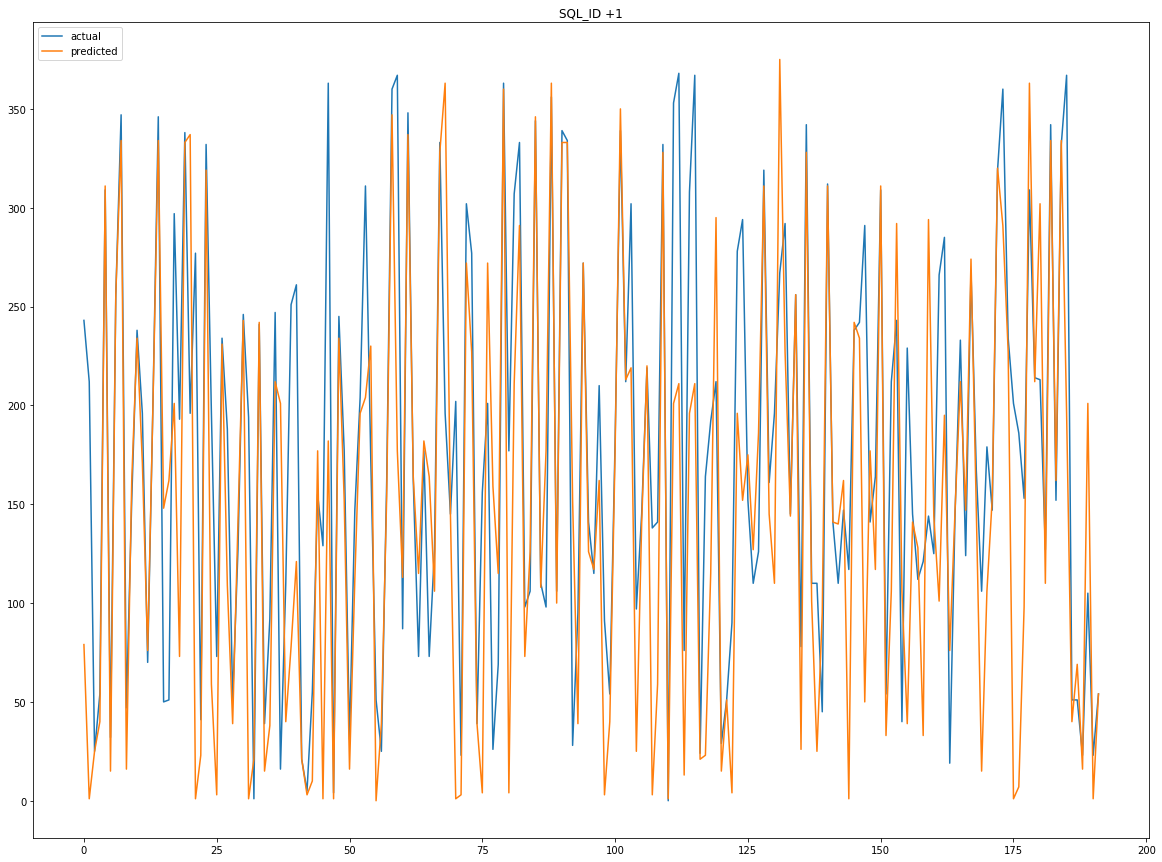

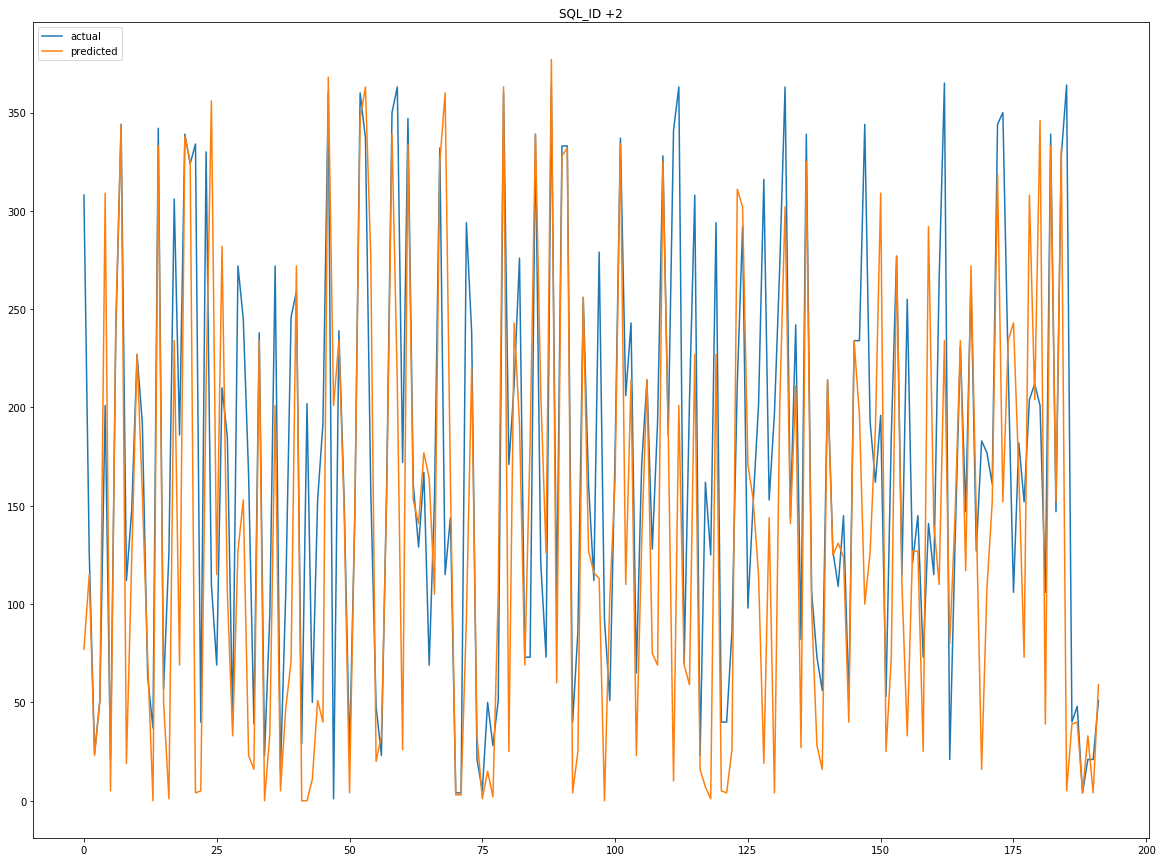

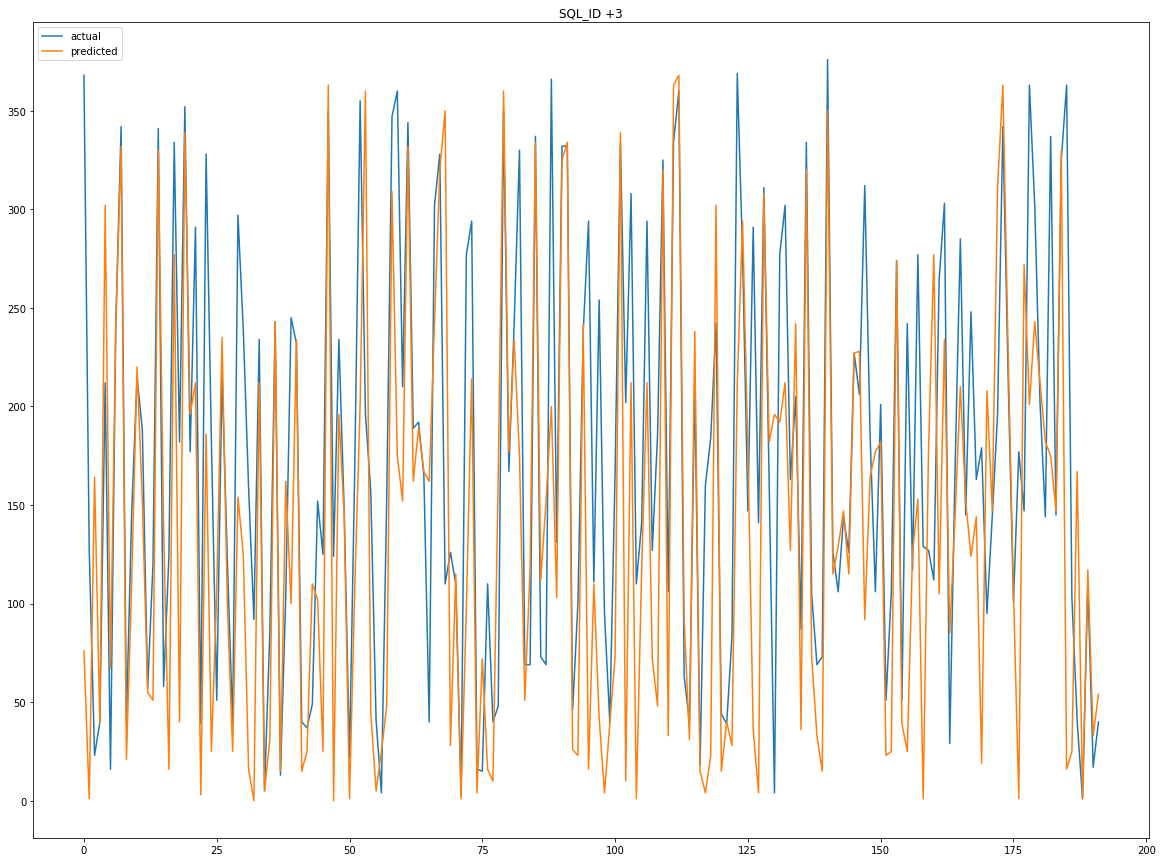



Training + Testing
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Test FScore SQL_ID with LAG value [0]: 0.015625
Test FScore SQL_ID with LAG value [1]: 0.03125
Test FScore SQL_ID with LAG value [2]: 0.010416666666666666


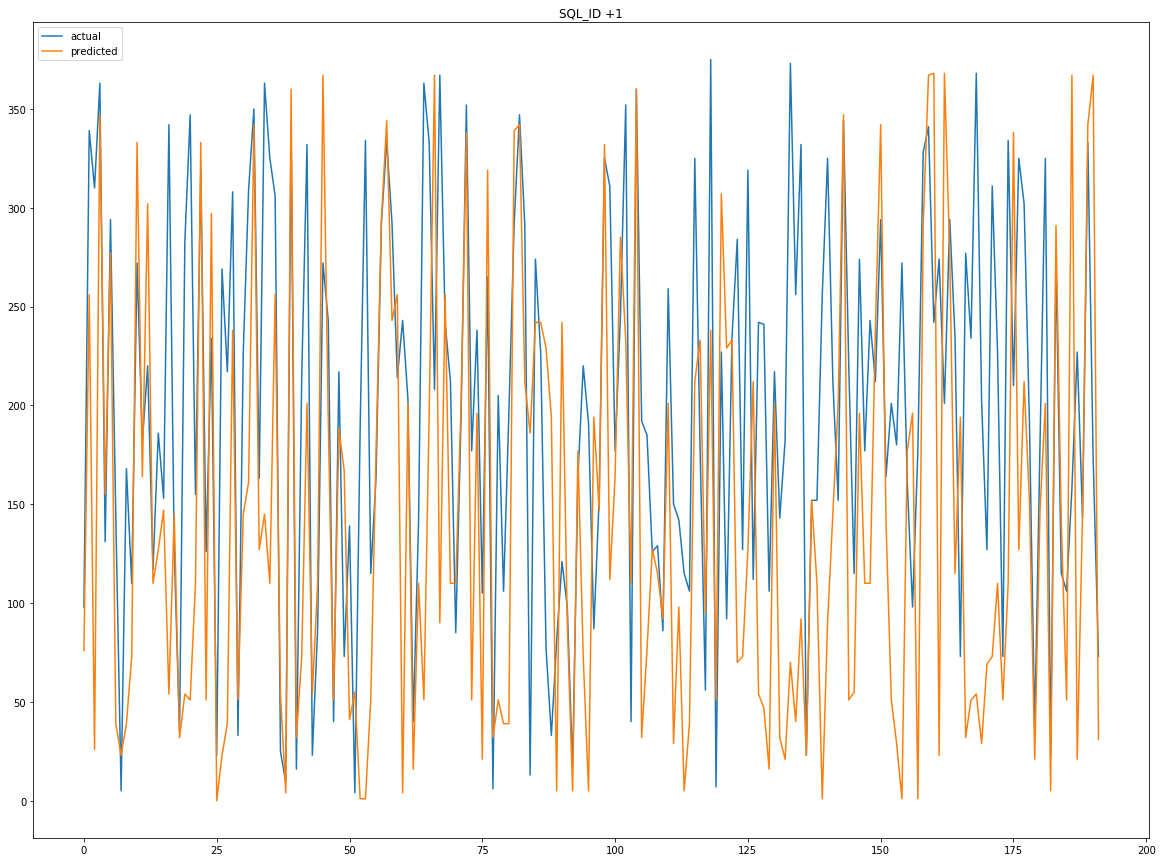

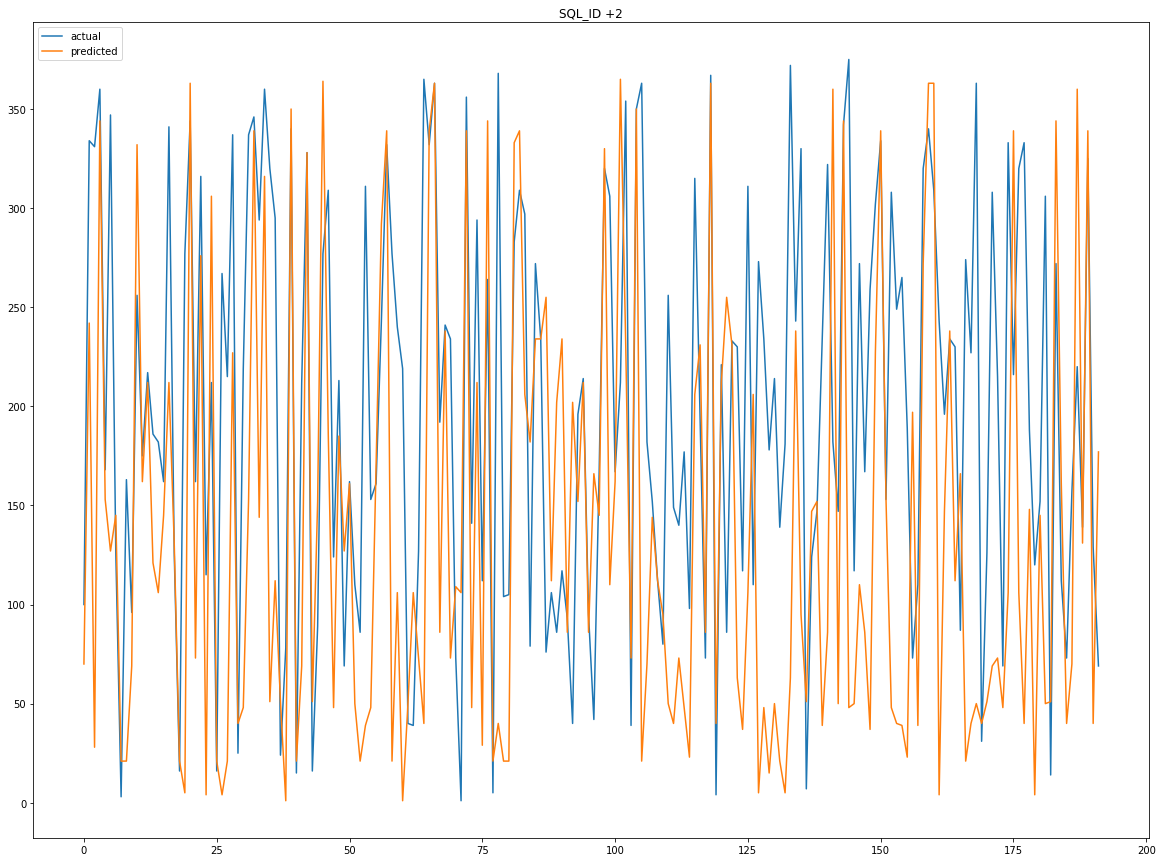

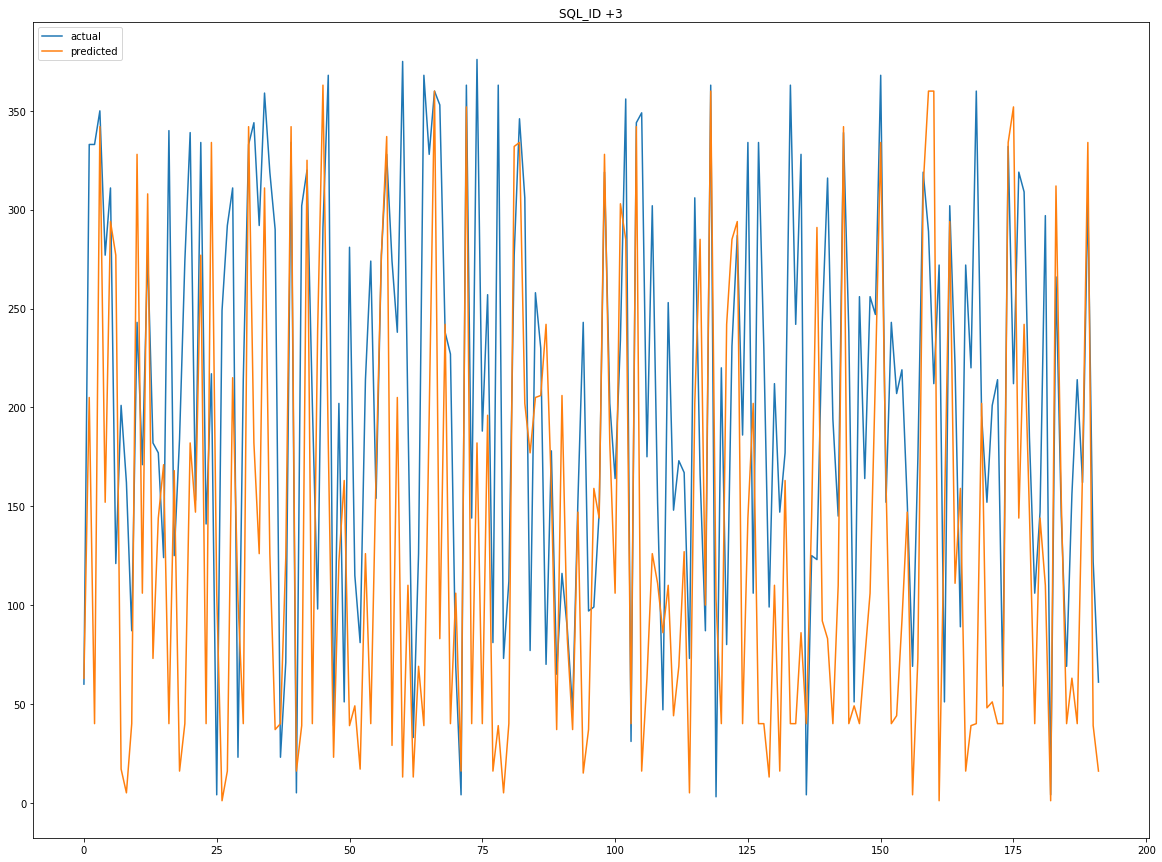

In [29]:
X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))
#
X_validate, X_test, y_validate, y_test = train_test_split(X_validate, y_validate, test_size=.5)
X_validate = X_validate.values
X_test = X_test.values
y_validate = y_validate.values
y_test = y_test.values
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))
print("X_test shape [" + str(X_test.shape) + "] Type - " + str(type(X_test)))
print("y_test shape [" + str(y_test.shape) + "] Type - " + str(type(y_test)) + "\n------------------------------")
#
print(X_train[0:5])
print(y_train[0:5])
print('------------------------------------------------------------')
print(X_validate[0:5])
print(y_validate[0:5])
print('------------------------------------------------------------')
print(X_test[0:5])
print(y_test[0:5])
#
# Train on discrete data (Train > Validation)
print('Training + Validation')
model = RandomForest(mode='classification',
                     n_estimators=n_estimators,
                     parallel_degree=parallel_degree)
model.fit_model(X_train=X_train,
                y_train=y_train)
model.predict_and_evaluate(X=X_validate,
                           y=y_validate,
                           y_labels=y_label,
                           plot=True)
#
# Train on discrete data (Train + Validation > Test)
print('\n\nTraining + Testing')
model.fit_model(X_train=X_validate,
                y_train=y_validate)
model.predict_and_evaluate(X=X_test,
                           y=y_test,
                           y_labels=y_label,
                           plot=True)